<a href="https://colab.research.google.com/github/sayakpaul/near-dup-parser/blob/main/bit-near-dup-parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Fetching similar images in (near) real time is an important use-case in information retrieval systems. Some popular examples utilizing this include Pinterest, Google Image Search, etc. In this example, we will build a similar image parsing utility using [Locality Sensitive Hashing](https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134) (LSH) and [Random Projection](https://en.wikipedia.org/wiki/Random_projection) on top of a pre-trained image classifier. We will also look into optimizing the performance of our parser given a commodity GPU-based environment. These kinds of parsers are also known as _near duplicate (or near-dup) image detectors_. 

There are other examples in [keras.io/examples/vision](https://keras.io/examples/vision) that are worth checking out in this regard:

* [Metric learning for image similarity search](https://keras.io/examples/vision/metric_learning)
* [Image similarity estimation using a Siamese Network with a triplet loss](https://keras.io/examples/vision/siamese_network)

Finally, this example uses the following resource as a reference and as such reuses code from there: [Locality Sensitive Hashing for Similar Item Search](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23).

_Note that in order to optimize the performance of our parser, you should be connected to a GPU._

## Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Load dataset and create a training set of 1000 images

To keep the runtime of the example short, we will be using a subset of 1000 images from the `tf_flowers` dataset (available through [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/tf_flowers)) to build our vocabulary. 

In [2]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
IMAGE_SIZE = 224
NUM_IMAGES = 1000

images = []
labels = []

for (image, label) in train_ds.take(NUM_IMAGES):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    images.append(image.numpy())
    labels.append(label.numpy())

images = np.array(images)
labels = np.array(labels)

## Pre-trained model

In this section, we load our image classification model that was trained on the `tf_flowers` dataset. 85% of the total images were used to build the training set. For more details on the training, you check out [this notebook](https://github.com/sayakpaul/near-dup-parser/blob/main/bit-supervised-training.ipynb).

The underlying model is a BiT-ResNet (proposed in [Big Transfer (BiT): General Visual Representation Learning](https://arxiv.org/abs/1912.11370)). BiT-ResNet family of models are known to have excellent transfer performance across a wide variety of different downstream tasks. 

In [4]:
!wget -q https://git.io/JuMq0 -O flower_model_bit_0.96875.zip
!unzip -qq flower_model_bit_0.96875.zip

In [5]:
bit_model = tf.keras.models.load_model("flower_model_bit_0.96875")
bit_model.count_params()

23510597

## Create an embedding model

To parse the similar images given a query image, we need to first generate vector representations of the images. For this purpose, we will be branching the above image classifier such that it becomes apt for our purpose. 

In [6]:
embedding_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        tf.keras.layers.Rescaling(scale=1.0 / 255),
        bit_model.layers[1],
        tf.keras.layers.Normalization(mean=0, variance=1),
    ],
    name="embedding_model",
)

embedding_model.summary()

Model: "embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
normalization (Normalization (None, 2048)              0         
Total params: 23,500,352
Trainable params: 23,500,352
Non-trainable params: 0
_________________________________________________________________


Take note of the normalization layer inside the model. It is used to project the representation vectors to the space of unit-spheres.

## Hashing utilities

In [7]:
def hash_func(embedding, random_vectors):
    if not isinstance(embedding, np.ndarray):
        embedding = embedding.numpy()

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y

The dimensionality coming out of `embedding_model` is (2048, ) and considering practical aspects (storage, retrieval performance, etc.) it is quite large. So, there arises a need to reduce this dimensionality without reducing the information content. This is where Random Projections come into the picture. It is based on the principle that if the distance between a group of points on a given plane is _approximately_ preserved the dimensionality of that plane can further be reduced. 

Inside `hash_func()`, we first reduce the dimensionality of the embedding vectors. Then we compute the bitwise hash values of the images to determine their hash buckets. Images having same hash values are likely to go into the same hash bucket. From a deployment perspective, bitwise hash values are cheaper to store and operate on.

## LSH builders

The `Table` class is responsible for building a single hash table. Each entry in the hash table is a mapping between the reduced embedding of an image from our dataset and a unique identifier. Because our dimensionality reduction technique involves randomness, it can so happen that similar images are not mapped to the same hash bucket everytime the process run. So, to reduce this effect, we will take results from multiple tables into consideration. So, the number of tables and the reduction dimensionality are the key hyperparameters here. 

In [8]:
class Table:
    def __init__(self, hash_size, dim):
        self.table = dict()
        self.hash_size = hash_size
        self.random_vectors = np.random.randn(hash_size, dim).T

    def add(self, id, vecs, label):
        # Create a unique indentifier.
        entry = {"id_label": str(id) + "_" + str(label)}

        # Compute the hash values.
        hashes = hash_func(vecs, self.random_vectors)

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vecs):
        # Compute hash value for the query vector.
        hashes = hash_func(vecs, self.random_vectors)
        results = list()

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results

In the following `LSH` class we will pack the utilities to have multiple hash tables. 

In [9]:
class LSH:
    def __init__(self, hash_size, dim, num_tables):
        self.num_tables = num_tables
        self.tables = list()
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size, dim))

    def add(self, id, vecs, label):
        for table in self.tables:
            table.add(id, vecs, label)

    def query(self, vecs):
        results = list()
        for table in self.tables:
            results.extend(table.query(vecs))
        return results

Now we can encapsulate the logic for building and operating with the master LSH table (a collection of many tables) inside a class. It has two methods:

* `train()`: Responsible for building the final LSH table. 
* `query()`: Calculates the number of matches given a query image and also quantifies the similarity score.

In [10]:
class BuildLSHTable:
    def __init__(
        self,
        prediction_model,
        concrete_function=False,
        hash_size=8,
        dim=2048,
        num_tables=10,
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.dim, self.num_tables)

        self.prediction_model = prediction_model
        self.concrete_function = concrete_function

    def train(self, training_files):
        for id, training_file in enumerate(training_files):
            # Unpack the data.
            image, label = training_file
            if len(image.shape) < 4:
                image = image[None, ...]

            # Compute embeddings and update the LSH tables.
            # More on `self.concrete_function()` later.
            if self.concrete_function:
                features = self.prediction_model(tf.constant(image))["normalization"].numpy()
            else:
                features = self.prediction_model.predict(image)
            self.lsh.add(id, features, label)

    def query(self, image, verbose=True):
        # Compute the embeddings of the query image and fetch the results.
        if len(image.shape) < 4:
            image = image[None, ...]

        if self.concrete_function:
            features = self.prediction_model(tf.constant(image))["normalization"].numpy()
        else:
            features = self.prediction_model.predict(image)

        results = self.lsh.query(features)
        if verbose:
            print("Matches:", len(results))

        # Calculate Jaccard index to quantify the similarity.
        counts = {}
        for r in results:
            if r["id_label"] in counts:
                counts[r["id_label"]] += 1
            else:
                counts[r["id_label"]] = 1
        for k in counts:
            counts[k] = float(counts[k]) / self.dim
        return counts

## Create LSH tables

With our helper utilities and classes implemented, we can now build our LSH table. Since we will be benchmarking performance between optimized and unoptimized embedding models we will also warm up our GPU to avoid any unfair comparison. 

In [11]:
def warmup():
    dummy_sample = tf.ones((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    for _ in range(100):
        _ = embedding_model.predict(dummy_sample)

In [12]:
warmup()

training_files = zip(images, labels)
lsh_builder = BuildLSHTable(embedding_model)
%time lsh_builder.train(training_files)

CPU times: user 1min 1s, sys: 50.8 s, total: 1min 52s
Wall time: 55.2 s


At the time of writing the wall time was 54.1 seconds on a Tesla T4 GPU. This timing may vary based on the GPU you are using.

## Optimizing the model with TensorRT

For NVIDIA-based GPUs, the [TensorRT framework](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html) can be used to dramatically enhance the inference latency by using various model optimization techniques like pruning, constant folding, layer fusion, and so on. Here we will use the [`tf.experimental.tensorrt`](https://www.tensorflow.org/api_docs/python/tf/experimental/tensorrt) module to optimize our embedding model.

In [13]:
# First serialize the embedding model as a SavedModel.
embedding_model.save("embedding_model")

# Initialize the conversion parameters.
params = tf.experimental.tensorrt.ConversionParams(
    precision_mode="FP16", maximum_cached_engines=16
)

# Run the conversion.
converter = tf.experimental.tensorrt.Converter(
    input_saved_model_dir="embedding_model", conversion_params=params
)
converter.convert()
converter.save("tensorrt_embedding_model")

INFO:tensorflow:Assets written to: embedding_model/assets


INFO:tensorflow:Assets written to: embedding_model/assets


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: tensorrt_embedding_model/assets


INFO:tensorflow:Assets written to: tensorrt_embedding_model/assets


**Notes on the parameters inside of `tf.experimental.tensorrt.ConversionParams()`**:

* `precision_mode` defines the numerical precision of the operations in the to-be-converted model.
* `maximum_cached_engines` specifies the maximum number of TRT engines that will be cached to handle dynamic operations (operations with unknown shapes). 

To know more about the other options, check out the [official documentation](https://www.tensorflow.org/api_docs/python/tf/experimental/tensorrt/ConversionParams). You can also explore the different quantization options provided by the `tf.experimental.tensorrt` module catering to different purposes. 

In [14]:
# Load the converted model.
root = tf.saved_model.load("tensorrt_embedding_model") 
trt_model_function = root.signatures["serving_default"]

## Build LSH tables with optimized model

In [15]:
warmup()

training_files = zip(images, labels)
lsh_builder_trt = BuildLSHTable(trt_model_function, concrete_function=True)
%time lsh_builder_trt.train(training_files)

CPU times: user 17.4 s, sys: 12.3 s, total: 29.7 s
Wall time: 16.2 s


Notice the difference in the wall time which is **13.1 seconds**. Earlier, with the unoptimized model it was **54.1 seconds**. 

We can take a closer look into one of the hash tables and get an idea of how they are represented. 

In [16]:
idx = 0
for hash, entry in lsh_builder_trt.lsh.tables[0].table.items():
    if idx == 5:
        break
    if len(entry) < 5:
        print(hash, entry)
        idx += 1

133 [{'id_label': '9_1'}, {'id_label': '995_1'}]
254 [{'id_label': '12_4'}, {'id_label': '16_1'}, {'id_label': '847_0'}]
167 [{'id_label': '13_1'}, {'id_label': '503_1'}]
214 [{'id_label': '24_1'}, {'id_label': '250_1'}]
165 [{'id_label': '25_1'}, {'id_label': '445_2'}]


## Visualization with validation images

In this section we will first writing a couple of utility functions to visualize the similar image parsing process. Then we will benchmark the query performance of the models with and without optimization. 

In [17]:
validation_images = []
validation_labels = []

for image, label in validation_ds.take(100):
    image = tf.image.resize(image, (224, 224))
    validation_images.append(image.numpy())
    validation_labels.append(label.numpy())

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)
validation_images.shape, validation_labels.shape

((100, 224, 224, 3), (100,))

In [18]:
def plot_images(images, labels):
    plt.figure(figsize=(20, 10))
    columns = 5
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(labels[i]))
        else:
            ax.set_title("Similar Image # " + str(i) +
                         "\nLabel: {}".format(labels[i]))
        plt.imshow(image.astype("int"))
        plt.axis("off")

In [19]:
def visualize_lsh(lsh_class):
    idx = np.random.choice(len(validation_images))
    image = validation_images[idx]
    label = validation_labels[idx]
    results = lsh_class.query(image)

    candidates = []
    labels = []
    overlaps = []

    for idx, r in enumerate(sorted(results, key=results.get, reverse=True)):
        if idx == 4:
            break
        image_id, label = r.split("_")[0], r.split("_")[1]
        candidates.append(images[int(image_id)])
        labels.append(label)
        overlaps.append(results[r])

    candidates.insert(0, image)
    labels.insert(0, label)

    plot_images(candidates, labels)

### Non-TRT model

Matches: 251
Matches: 487
Matches: 166
Matches: 483
Matches: 387


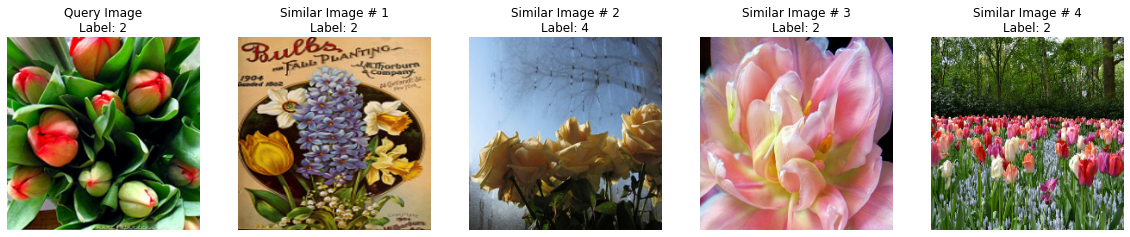

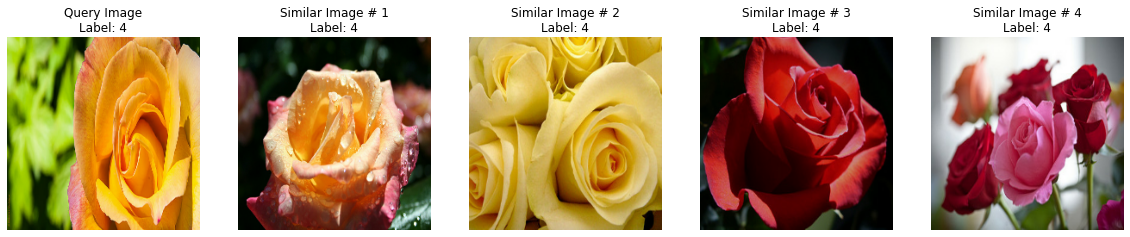

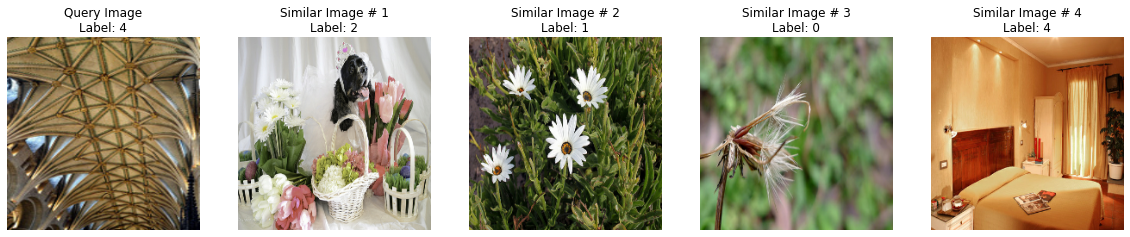

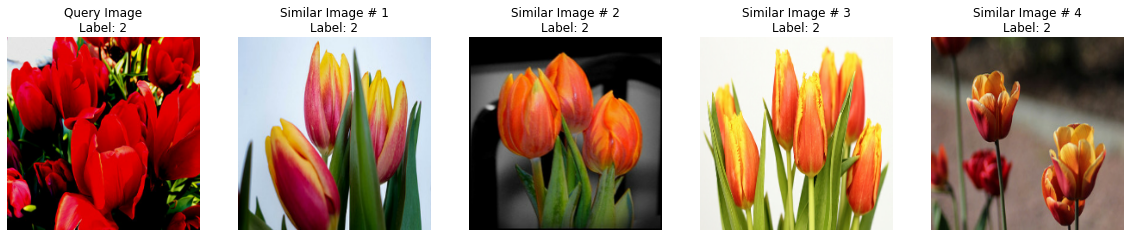

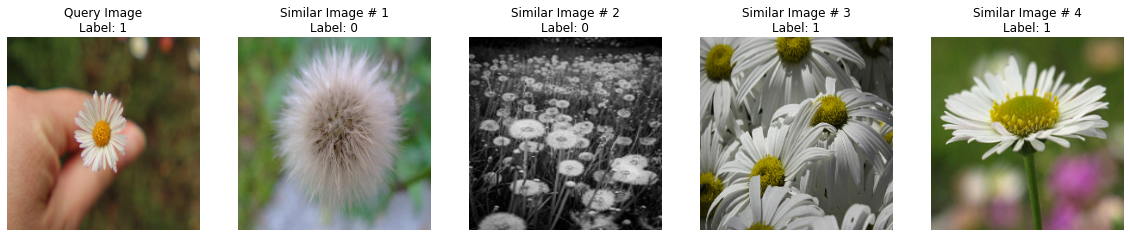

In [20]:
for _ in range(5):
    visualize_lsh(lsh_builder)

Matches: 311


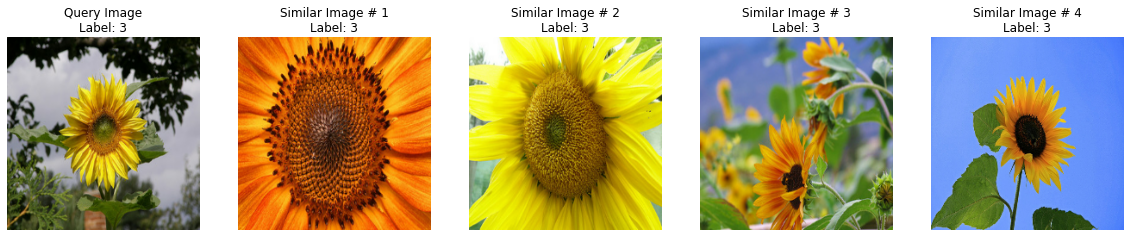

In [21]:
visualize_lsh(lsh_builder)

### TRT model

Matches: 325
Matches: 983
Matches: 630
Matches: 358
Matches: 526


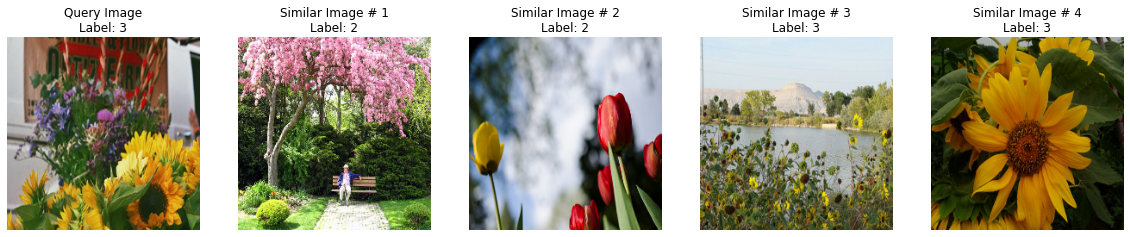

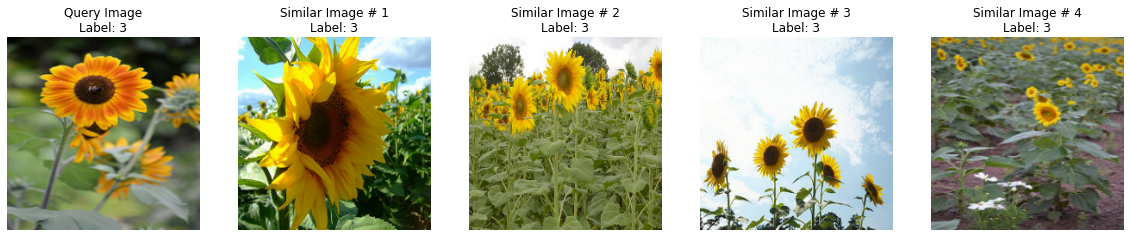

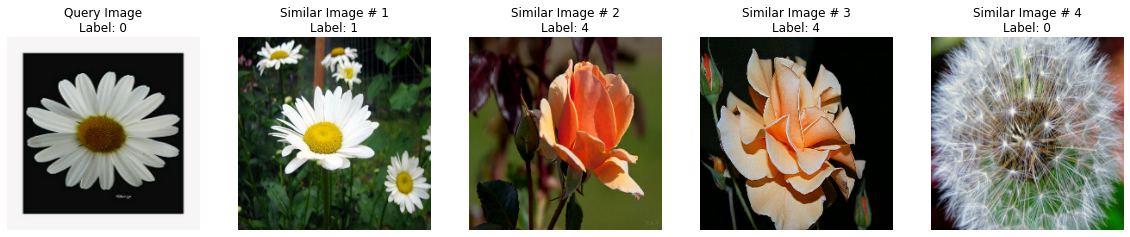

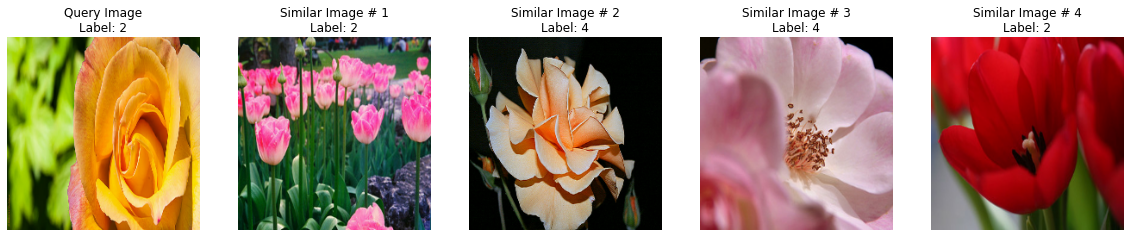

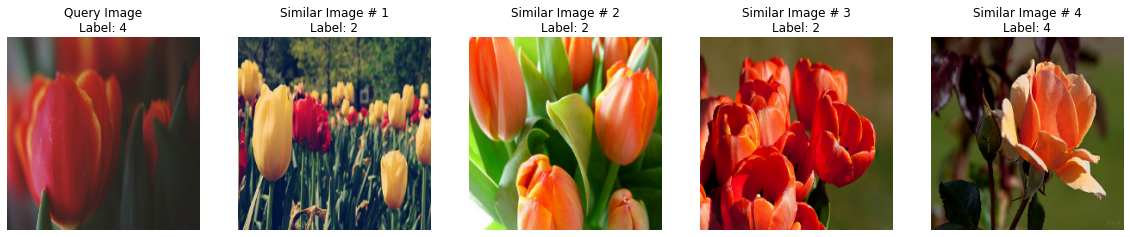

In [22]:
for _ in range(5):
    visualize_lsh(lsh_builder_trt)

As you may have spotted there are a couple of incorrect results. This can be mitigated in a couple of ways:

* Better model for generating the initial embeddings especially for noisy samples. We can use techniques like [ArcFace](https://arxiv.org/abs/1801.07698), [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362), etc. that implicitly encourage better learning of representations for retrieval purposes. 
* Trade-off between the number of tables and the reduction dimensionality is very crucial and it helps set the right recall required for your application.

## Benchmarking query performance

In [23]:
def benchmark(lsh_class):
    start_time = time.time()
    for _ in range(1000):
        image = np.ones((1, 224, 224, 3)).astype("float32")
        _ = lsh_class.query(image, verbose=False)
    end_time = time.time() - start_time
    print(f"Time taken: {end_time:.3f}")

In [24]:
benchmark(lsh_builder)

Time taken: 55.104


In [25]:
benchmark(lsh_builder_trt)

Time taken: 14.010


We can immediately notice a stark difference in betwee the query performance of the two models. 

## Final remarks

In this example, we explored the TensorRT framework from NVIDIA for optimizing our model. It's best suited for GPU-based inference servers. There are other choices for such frameworks that cater to different hardware platforms:

* [TensorFlow Lite](https://www.tensorflow.org/lite) for mobile and edge devices.
* [ONNX](hhttps://onnx.ai/) for commodity CPU-based servers. 
* [Apache TVM](https://tvm.apache.org/), compiler for machine learning models covering various platforms.

FInally, here are a few resources you might want to check out in case you want to know more about vector similary search in general:

* [ANN Benchmarks](http://ann-benchmarks.com/)
* [Accelerating Large-Scale Inference with Anisotropic Vector Quantization (ScaNN)](https://arxiv.org/abs/1908.10396)
* [Spreading vectors for similarity search](https://arxiv.org/abs/1806.03198)
* [Building a real-time embeddings similarity matching system](https://cloud.google.com/architecture/building-real-time-embeddings-similarity-matching-system)